<a href="https://colab.research.google.com/github/fsantamaria1/Bird_Classification/blob/main/Bird_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Bird Species Classification

In [40]:
#Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pathlib
import os
import tensorflow as tf
import tensorflow_hub as hub
import random
import matplotlib.image as mpimg

In [21]:
# # Unzip files
# !unzip "drive/MyDrive/BirdClasses/525-bird-species.zip" -d "drive/My Drive/BirdClasses/"

Streaming output truncated to the last 5000 lines.
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/120.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/121.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/122.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/123.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/124.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/125.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/126.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/127.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/128.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/129.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/130.jpg  
  inflating: drive/My Drive/BirdClasses/train/WHITE TAILED TROPIC/131.jpg  
  inflating: drive/My Drive/BirdClass

In [45]:
# List directories
data_dir = "drive/My Drive/BirdClasses/"
train_dir = "drive/My Drive/BirdClasses/train/"
test_dir = "drive/My Drive/BirdClasses/test/"
valid_dir = "drive/My Drive/BirdClasses/valid"

In [66]:

def view_rand_image(directory, bird_class):
  #Create the entire path
  path = directory + bird_class

  #Get an image from the path
  image = random.sample(os.listdir(path), 1)

  image_path = path + "/" + image[0]

  #Plot the image
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(bird_class)
  plt.axis("off")

  print(f"Image shape: {img.shape}")

  return img


In [67]:
birds_csv_dir = data_dir + "birds.csv"
birds_csv = pd.read_csv(birds_csv_dir)
birds_csv.tail()

,class id,filepaths,labels,data set,scientific name
89880,524.0,valid/BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89881,524.0,valid/BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89882,524.0,valid/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89883,524.0,valid/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS
89884,524.0,valid/BLACK BREASTED PUFFBIRD/5.jpg,BLACK BREASTED PUFFBIRD,valid,NOTHARCHUS PECTORALIS


Image shape: (224, 224, 3)


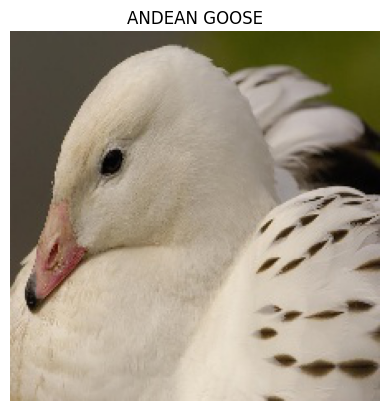

In [69]:
#View random image
img = view_rand_image(train_dir, birds_csv["labels"][4000])